Copyright 2021 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This colab accompanies the paper 'Spurious normativity enhances learning of compliance and enforcement behavior in artificial agents' in PNAS 2022 by Koster et al.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats
import seaborn as sns
import tempfile
from google.colab import files
import warnings
warnings.simplefilter('ignore', category=RuntimeWarning)

# Load Data.

In [ ]:
f = tempfile.NamedTemporaryFile()

In [ ]:
!gsutil cp "gs://dm_spurious_normativity/spurious_normativity.pkl" {f.name}

In [ ]:
with open(f.name, 'rb') as pickle_file:
  data = pickle.load(pickle_file)
population_data = data[0]
probe_data = data[1]

# Population Data

population_data contains data from the 3 conditions: 

* 'no rule', 
* 'important rule',
* 'silly rule'

Each of those conditions has 7 variables that were logged for each
population.

* Collective Return
* Total Berries Eaten
* Total Taboo Berries Eaten
* Total Punishments
* Total Misdirected Punishing
* Fraction of Time Spent Marked
* Fracton of Time Spent Poisoned

Each entry is indexed by a combination of the condition and metric, e.g.:
'important rule Collective Return'

Each of those entries contains a list, containing different populations.
5 for no rule, 15 for the other two conditions.

Each population consists of a tuple: the data of the x and y axis to plot this metric in that particular condition of one population.


# Probe data

probe_data contains 15 variables that respond to a probe task in one
experimental condition. The variables are, for the no rules condition:

 * 'no_rule_berry_1' - how quickly berry 1 was approached, the actually poisonous berry.

* 'no_rule_berry_2' - how quickly berry 2 was approached, the harmless berry that
  is taboo in the silly rules condition.

* 'no_rule_berry_healthy' - how quickly other berries were approached.

* 'no_rule_zap_marked' - how quickly a marked player was zapped.

* 'no_rule_zap_unmarked' - how quickly the unmarked players were zapped.

These metrics are repeated for the important_rule and silly_rule condition:

* 'important_rule_berry_1'

* 'important_rule_berry_2'

* 'important_rule_healthy'

* 'important_zap_marked'

* 'important_zap_unmarked'

* 'silly_rule_berry_1'

* 'silly_rule_berry_2'

* 'silly_rule_healthy'
  
* 'silly_zap_marked'

* 'silly_zap_unmarked'

Each entry contains an array with the shape [N, 20]. N is the number of
independent populations that were run and the 20 refers to the number of samples
along the training trajectory for which the probes were ran. N = 5 for no_rule
and N = 15 for silly_rule and important_rule.

# Figure 4

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

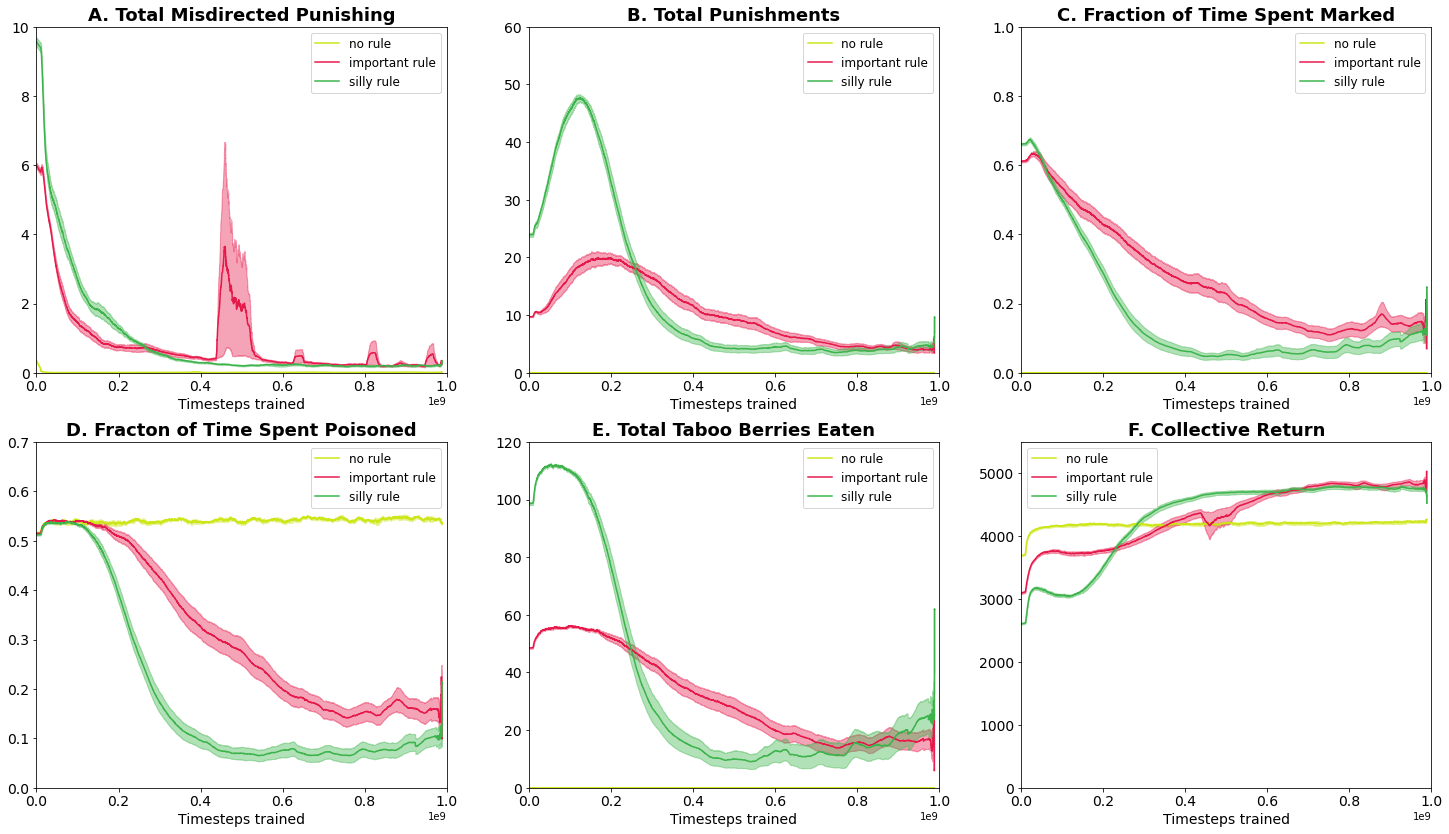

In [ ]:
n_rows = 2
n_cols = 3

condition_legends = ['no rule', 'important rule', 'silly rule']
colors_per_condition = [(.8, .9, 25./255),
                        (230./255, 25./255, 75./255),
                        (60./255, 180./255, 75./255)]

metrics_titles = ['Total Misdirected Punishing',
                  'Total Punishments',
                  'Fraction of Time Spent Marked',
                  'Fracton of Time Spent Poisoned',
                  'Total Taboo Berries Eaten',
                  'Collective Return']

alphabet = ['A. ', 'B. ', 'C. ', 'D. ', 'E. ', 'F. ']
y_lims_per_metric = [(0, 10),
                     (0, 60),
                     (0, 1),
                     (0, 0.7),
                     (0, 120),
                     (0, 5500)]

plotcounter = 1
plt.figure(facecolor='white')
fig, ax = plt.subplots(n_rows, n_cols, figsize=(25, n_rows*7), facecolor='w')
for metric, letter, y_lims in zip(
    metrics_titles, alphabet, y_lims_per_metric):
  plt.subplot(n_rows, n_cols, plotcounter)
  for condition, line_color in zip(condition_legends, colors_per_condition):
    entry = condition + ' ' + metric
    condition_data = population_data[entry]
    # The data do not have the same shape so we need to put them on a
    # canvas of nans to concatenate them.
    data_frame_for_mean = np.empty((int(1e5), len(condition_data)))
    data_frame_for_mean.fill(np.nan)
    for p, population in enumerate(condition_data):
      trajectory = condition_data[p][1]
      data_frame_for_mean[0:trajectory.shape[0], p] = trajectory

    y = np.nanmean(data_frame_for_mean, axis=1)
    # SEM
    y_error = np.divide(
        np.nanstd(data_frame_for_mean, axis=1),
        np.sqrt(len(condition_data)))
    x = np.arange(0, 1e9, 1e4)
    plt.plot(x, y, color=line_color)
    plt.fill_between(x, y-y_error, y+y_error, alpha=0.4,
                     color=line_color, label='_nolegend_')
  plt.title(letter +  metric, fontsize=18, fontweight='bold')
  plt.legend(condition_legends, loc='best', fontsize=12)
  plt.xlabel('Timesteps trained', fontsize=14)
  plt.xlim(0, 1e9)
  plt.ylim(y_lims)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plotcounter += 1

plt.savefig('fig4.png', dpi=500)
files.download('fig4.png')

In [ ]:
# Statistics for Fig 4 plot, t-tests per timebin
populations = 15
timebins = 10
start_x = 0
end_x = 1e8

for tb in range(timebins):
  silly_means = np.zeros((populations))
  important_means = np.zeros((populations))

  for p in range(populations):
    silly_x = population_data['silly rule Collective Return'][p][0]
    silly_y = population_data['silly rule Collective Return'][p][1]
    silly_index = (silly_x > start_x) & (silly_x < end_x)
    silly_mean = np.nanmean(silly_y[silly_index])
    silly_means[p] = silly_mean

    important_x = population_data['important rule Collective Return'][p][0]
    important_y = population_data['important rule Collective Return'][p][1]
    important_index = (important_x > start_x) & (important_x < end_x)
    important_mean = np.nanmean(important_y[important_index])
    important_means[p] = important_mean

  t, p = scipy.stats.ttest_ind(silly_means, important_means)
  print('For timebin ', tb+1, ' from ', start_x, ' to ', end_x)
  print('Difference between silly and important rule condition:')
  print('t =', np.round(t, decimals=3), ', p =', np.round(p, decimals=4))

  start_x += 1e8
  end_x += 1e8

For timebin  1  from  0  to  100000000.0
Difference between silly and important rule condition:
t = -22.346 , p = 0.0
For timebin  2  from  100000000.0  to  200000000.0
Difference between silly and important rule condition:
t = -15.622 , p = 0.0
For timebin  3  from  200000000.0  to  300000000.0
Difference between silly and important rule condition:
t = 1.226 , p = 0.2305
For timebin  4  from  300000000.0  to  400000000.0
Difference between silly and important rule condition:
t = 3.941 , p = 0.0005
For timebin  5  from  400000000.0  to  500000000.0
Difference between silly and important rule condition:
t = 3.256 , p = 0.003
For timebin  6  from  500000000.0  to  600000000.0
Difference between silly and important rule condition:
t = 2.429 , p = 0.0218
For timebin  7  from  600000000.0  to  700000000.0
Difference between silly and important rule condition:
t = 0.213 , p = 0.8329
For timebin  8  from  700000000.0  to  800000000.0
Difference between silly and important rule condition:
t = 

# Figure 5

In [ ]:
fig_5_conditions = ['important rule', 'silly rule']
fig_5_metrics = ['Total Punishments', 'Fracton of Time Spent Poisoned']
cutoffs = [(0, 2e8), (2e8, 4e8)]
data_for_correlation = {}
for condition in fig_5_conditions:
  for metric, cutoff in zip(fig_5_metrics, cutoffs):
    entry_name = condition + ' ' + metric
    data_in_entry = population_data[entry_name]
    mean_values = np.zeros(len(data_in_entry))
    for i, d in enumerate(data_in_entry):
      x = d[0]
      y = d[1]
      index_vec = np.where((x > cutoff[0]) & (x < cutoff[1]))
      mean_values[i] = np.mean(y[index_vec])
    data_for_correlation[entry_name] = mean_values

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

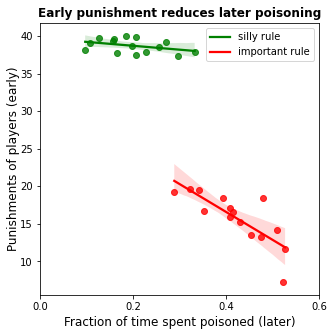

In [ ]:
fig = plt.figure(figsize=(5, 5), facecolor='white')
ax = fig.add_subplot(111)
sns.regplot(x=data_for_correlation['silly rule Fracton of Time Spent Poisoned'],
            y=data_for_correlation['silly rule Total Punishments'],
            color='green')
sns.regplot(x=data_for_correlation['important rule Fracton of Time Spent Poisoned'],
            y=data_for_correlation['important rule Total Punishments'],
            color='red')
plt.xlabel('Fraction of time spent poisoned (later)', fontsize=12)
plt.ylabel('Punishments of players (early)', fontsize=12, labelpad=0)

plt.title('Early punishment reduces later poisoning', fontweight='bold')
plt.legend(['silly rule', 'important rule'], loc='upper right')
plt.xticks([0, .2, .4, .6])

plt.savefig('fig5.png', dpi=500)
files.download('fig5.png')

In [ ]:
# Statistics for Fig 5 plot
sr_corr_pop = scipy.stats.pearsonr(
    data_for_correlation['silly rule Fracton of Time Spent Poisoned'],
    data_for_correlation['silly rule Total Punishments'])

ir_corr_pop = scipy.stats.pearsonr(
    data_for_correlation['important rule Fracton of Time Spent Poisoned'],
    data_for_correlation['important rule Total Punishments'])

print('Silly Rule: r =', np.round(sr_corr_pop[0], decimals=3),
      'p =', np.round(sr_corr_pop[1], decimals=3))

print('Important Rule: r =', np.round(ir_corr_pop[0], decimals=3),
      'p =', np.round(ir_corr_pop[1], decimals=3))

Silly Rule: r = -0.39 p = 0.151
Important Rule: r = -0.799 p = 0.0


# Figure 6

In [ ]:
def error_line(var, color):
  ym = np.mean(var, axis=0)
  plt.plot(ym, color=color)
  ye = np.divide(np.nanstd(var, axis=0), np.sqrt(5))
  # x axis is always 20
  # because that is how often the agent was sampled during learning
  plt.fill_between(range(20), ym-ye, ym+ye, alpha=0.2, color=color)

def populate_axis():
  plt.ylim((0, 1))
  y_label = 'Timesteps until termination'
  plt.ylabel(y_label, fontsize=12, labelpad=-10)
  plt.yticks([0, 1], [0, 1])
  plt.yticks([0, 1], [30, 0])

  plt.xlim((0, 20))
  plt.xlabel('Timesteps trained', fontsize=12, labelpad=-10)
  plt.xticks([0, 20], ['0', '1e9'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

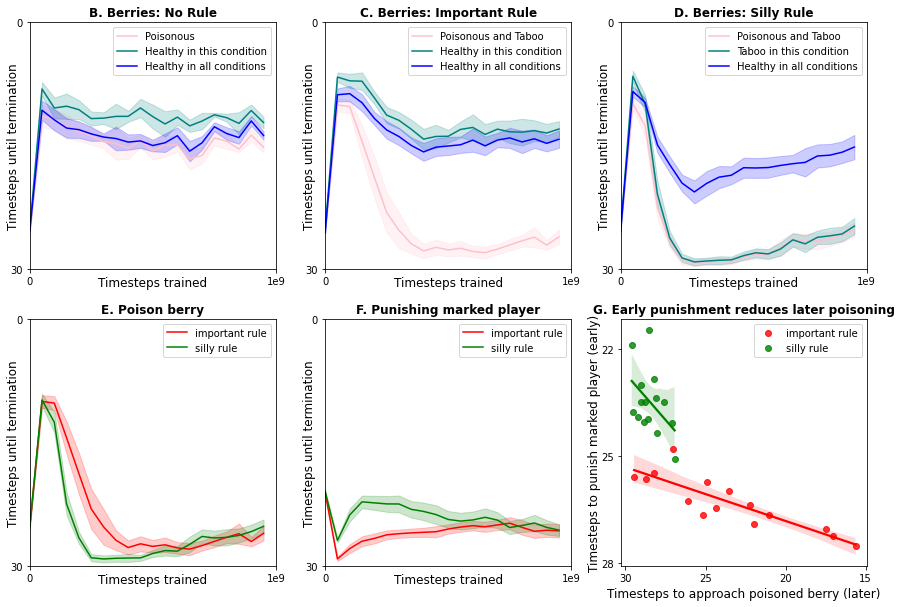

In [ ]:
plt.figure(facecolor='w')
fig, ax = plt.subplots(2, 3, figsize=(15, 10), facecolor='w')

plt.subplot(2, 3, 1)
error_line(probe_data['no_rule_berry_1'], 'pink')
error_line(probe_data['no_rule_berry_2'], 'teal')
error_line(probe_data['no_rule_berry_healthy'], 'blue')
populate_axis()
plt.legend(['Poisonous',
            'Healthy in this condition',
            'Healthy in all conditions'])
plt.title('B. Berries: No Rule', fontweight='bold')

plt.subplot(2, 3, 2)
error_line(probe_data['important_rule_berry_1'], 'pink')
error_line(probe_data['important_rule_berry_2'], 'teal')
error_line(probe_data['important_rule_healthy'], 'blue')
populate_axis()
plt.legend(['Poisonous and Taboo',
            'Healthy in this condition',
            'Healthy in all conditions'])
plt.title('C. Berries: Important Rule', fontweight='bold')

plt.subplot(2, 3, 3)
error_line(probe_data['silly_rule_berry_1'], 'pink')
error_line(probe_data['silly_rule_berry_2'], 'teal')
error_line(probe_data['silly_rule_healthy'], 'blue')
populate_axis()
plt.legend(['Poisonous and Taboo',
            'Taboo in this condition',
            'Healthy in all conditions'])
plt.title('D. Berries: Silly Rule', fontweight='bold')

plt.subplot(2, 3, 4)
error_line(probe_data['important_rule_berry_1'], 'red')
error_line(probe_data['silly_rule_berry_1'], 'green')
populate_axis()
plt.legend(['important rule', 'silly rule'])
plt.title('E. Poison berry', fontweight='bold')

plt.subplot(2, 3, 5)
error_line(probe_data['important_zap_marked'], 'red')
error_line(probe_data['silly_zap_marked'], 'green')
populate_axis()
plt.legend(['important rule', 'silly rule'])
plt.title('F. Punishing marked player', fontweight='bold')

marked_player_important_mean = np.mean(
    probe_data['important_zap_marked'][:, 0:4], axis=1)
marked_player_silly_mean = np.mean(
    probe_data['silly_zap_marked'][:, 0:4], axis=1)

berry1_important_mean = np.mean(
    probe_data['important_rule_berry_1'][:, 4:8], axis=1)
berry_1_silly_mean = np.mean(
    probe_data['silly_rule_berry_1'][:, 4:8], axis=1)

ax = plt.subplot(2, 3, 6)
# Multiply values by 30 because the probe episodes have 30 timesteps.
sns.regplot(x=berry_1_silly_mean*30, y=marked_player_silly_mean*30,
            color='green', label='silly rule')
sns.regplot(x=berry1_important_mean*30, y=marked_player_important_mean*30,
            color='red', label='important rule')
plt.xlabel('Timesteps to approach poisoned berry (later)', fontsize=12)
plt.ylabel('Timesteps to punish marked player (early)', fontsize=12, labelpad=0)
plt.xticks([0, 5, 10, 15], [30, 25, 20, 15])
plt.yticks([2, 5, 8], [28, 25, 22])
plt.title('G. Early punishment reduces later poisoning', fontweight='bold')
h, l = ax.get_legend_handles_labels()
ax.legend(reversed(h), reversed(l), loc='upper right')

plt.savefig('fig6.png', dpi=500)
files.download('fig6.png')

In [ ]:
# Stats for Figure 6 F
sr_corr_probe = scipy.stats.pearsonr(
    berry_1_silly_mean, marked_player_silly_mean)
ir_corr_probe = scipy.stats.pearsonr(
    berry1_important_mean, marked_player_important_mean)

print('Silly Rule: r =', np.round(sr_corr_probe[0], decimals=3),
      'p =', np.round(sr_corr_probe[1], decimals=3))

print('Important Rule: r =', np.round(ir_corr_probe[0], decimals=3),
      'p =', np.round(ir_corr_probe[1], decimals=3))

Silly Rule: r = -0.46 p = 0.085
Important Rule: r = -0.864 p = 0.0
